In [1]:
!pip install qiskit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 8.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.8/23.8 MB 23.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 25.3 MB/s eta 0:00:0000:0100:01
  Using cached ply-3.11-py2.py3-none-any.whl (49 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 20.2 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.5/107.5 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.2/536.2 kB 12.3 MB/s eta 0:00:0000:01


In [2]:
import numpy as np
import math
from matplotlib import pyplot as plt
import datetime
import random
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute, BasicAer

## Simulate the dynamic of the satellites

In [4]:
def durationVisibility(ground_station_number, satellite_number):
    time = 0; iteration = 0; duration = 0

    if satellite_number == 1 or satellite_number == 2:
        period = leo_period
    else:
        period = geo_period

    data = np.zeros(shape = (period, 3))
    while time < period:
        degrees = (360 / period) * time # 3.6 degrees per minute
        theta = math.radians(degrees)
        if satellite_number == 1: # no y direction
            x = (R_earth + leo_altitude) * np.cos(theta)
            y = 0
            z = (R_earth + leo_altitude) * np.sin(theta)
        elif satellite_number == 2: # no x direction
            x = (R_earth + leo_altitude) * np.cos(theta+ math.radians(45))
            y = 0
            z = (R_earth + leo_altitude) * np.sin(theta + math.radians(45))
        elif satellite_number == 3: # GEO 1
            x = (R_earth + geo_altitude) * np.cos(theta)
            y = (R_earth + geo_altitude) * np.sin(theta)
            z = 0
        data[iteration] = [x, y, z]

        if isVisible(data[iteration], ground_station_number):
            duration += 1

        time += 1; iteration += 1

    return data, duration

def isVisible(satellite, ground_station_number):
    if ground_station_number == 1:
        station = {'x': R_earth, 'y': 0, 'z': 0} # red point
    elif ground_station_number == 2:
        station = {'x': R_earth * np.cos(math.radians(75)), 'y': 0, 'z': R_earth * np.cos(math.radians(15))} # red/orange point

    distance = math.sqrt(math.pow(satellite[0] - station["x"], 2) + math.pow(satellite[1] - station["y"], 2) + math.pow(satellite[2] - station["z"], 2))

    if distance < max_range:
        return True
    else:
        return False

In [5]:
R_earth = 6371 # earth radius, km
leo_altitude = 780 # leo from earth, km
geo_altitude = 35786 # geo from earth, km
leo_period = 100 # LEO period, minutes
geo_period = 1440 # GEO period, minutes
max_range = 2000 # km, before a GS can't connect


# initialize positions
ground_station_1 = {'x': R_earth, 'y': 0, 'z': 0} # red point
ground_station_2 = {'x': R_earth * np.cos(math.radians(45)), 'y': 0, 'z': R_earth * np.cos(math.radians(45))} # green point
leo_sat_1 = {'x': R_earth + leo_altitude, 'y': 0, 'z': 0}
leo_sat_2 = {'x': (R_earth + leo_altitude) * np.cos(math.radians(45)), 'y': 0, 'z': (R_earth+leo_altitude)* np.sin(math.radians(45))}
geo_sat_1 = {'x': R_earth + geo_altitude, 'y': 0, 'z': 0}

Duration of connectivity of GS1-LEO1: 9
Duration of connectivity of GS1-LEO2: 8
Duration of connectivity of GS2-LEO1: 9
Duration of connectivity of GS2-LEO2: 9
Duration of connectivity of GS1-GEO1: 0


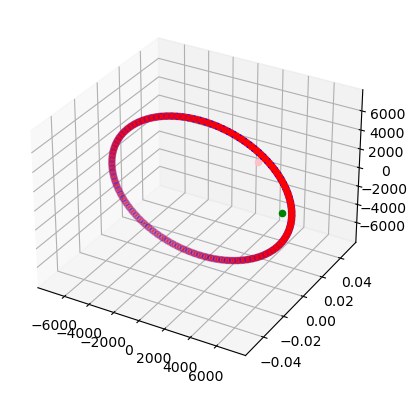

In [6]:
# data _ (station number)(leo/geo)(number), duration _ (station)
data_gs1l1, duration_gs1l1 = durationVisibility(1, 1)
data_gs1l2, duration_gs1l2 = durationVisibility(1, 2)

data_gs2l1, duration_gs2l1 = durationVisibility(2, 1)
data_gs2l2, duration_gs2l2 = durationVisibility(2, 2)

data_gs1g1, duration_gs1g1 = durationVisibility(1, 3)

print("Duration of connectivity of GS1-LEO1:", duration_gs1l1)
print("Duration of connectivity of GS1-LEO2:", duration_gs1l2)
print("Duration of connectivity of GS2-LEO1:", duration_gs2l1)
print("Duration of connectivity of GS2-LEO2:", duration_gs2l2)
print("Duration of connectivity of GS1-GEO1:", duration_gs1g1)

# transpose all the data
x1, y1, z1 = data_gs1l1.T
x2, y2, z2 = data_gs1l2.T
x3, y3, z3 = data_gs1g1.T

# plotting the data
fig = plt.figure()
ax = plt.axes(projection = "3d")
ax.set_aspect("auto")
ax.scatter3D(x1, y1, z1, c = "blue") # LEO sat 1
ax.scatter3D(x2, y2, z2, c = "red")  # LEO sat 2
# ax.scatter3D(x3, y3, z3, c = "pink")  # GEO sat 1

ax.scatter3D(ground_station_1["x"], ground_station_1["y"], ground_station_1["z"], c = "green")
ax.scatter3D(ground_station_2["x"], ground_station_2["y"], ground_station_2["z"], c = "pink")
# ax.scatter3D(geo_sat_1["x"], geo_sat_1["y"], geo_sat_1["z"], c = "black")
plt.show()

## Simulation!

Functions:

In [7]:
def durationVisibility(ground_station_number, satellite_number):
    time = 0; iteration = 0; duration = 0

    if satellite_number == 1 or satellite_number == 2:
        period = leo_period
    else:
        period = geo_period

    data = np.zeros(shape = (period, 3))
    while time < period:
        degrees = (360 / period) * time # 3.6 degrees per minute
        theta = math.radians(degrees)
        if satellite_number == 1: # no y direction
            x = (R_earth + leo_altitude) * np.cos(theta)
            y = 0
            z = (R_earth + leo_altitude) * np.sin(theta)
        elif satellite_number == 2: # no x direction
            x = (R_earth + leo_altitude) * np.cos(theta+ math.radians(45))
            y = 0
            z = (R_earth + leo_altitude) * np.sin(theta + math.radians(45))
        elif satellite_number == 3: # GEO 1
            x = (R_earth + geo_altitude) * np.cos(theta)
            y = (R_earth + geo_altitude) * np.sin(theta)
            z = 0
        data[iteration] = [x, y, z]

        if isVisible(data[iteration], ground_station_number):
            duration += 1

        time += 1; iteration += 1
    return data, duration

def cal_distance(node1, node2, t):
  x1,y1,z1 = node1.dynamics[t]
  x2,y2,z2 = node2.dynamics[t]
  return np.sqrt((x1-x2)**2+(y1-y2)**2+(z1-z2)**2)

def visual(satellite, gs):
    x,y,z = satellite.T
    xg,yg,zg = gs.T
   # plotting the data
    fig = plt.figure()
    ax = plt.axes(projection = "3d")
    ax.set_aspect("auto")
    ax.scatter3D(x, y, z, c = "blue") # satellite
    ax.scatter3D(xg, yg, zg, c = "green")

def do_bb84(n):
  qr = QuantumRegister(n, name = "qr")
  cr = ClassicalRegister(n, name = "cr")
  # initialize
  alice =  QuantumCircuit(qr, cr)
  bob = QuantumCircuit(qr, cr)

  # alice generating
  alice_basis = random.choices(["rectilinear", "diagonal"], k = 1)[0]
  alice_key = random.choices([0, 1], k = 1)[0]
  if alice_basis == "rectilinear":
    if alice_key == "1":
        alice.h(qr[0])
  else:
    if alice_key == "0":
        alice.h(qr[0])
        alice.s(qr[0])

  # bob randomly measuring qubits
  bob_basis = random.choices(["rectilinear", "diagonal"], k = 1)[0]
  if bob_basis == alice_basis:
    bob.h(qr[0])
  else:
    bob.h(qr[0])
    bob.s(qr[0])

  # measuring & simulate
  alice.measure(qr[0], cr[0])
  bob.measure(qr[0], cr[0])

  backend = BasicAer.get_backend("qasm_simulator")
  job = execute(alice, backend, shots = 1) # only want 1
  alice_result = job.result().get_counts()

  job = execute(bob, backend, shots = 1)
  bob_result = job.result().get_counts()

  if alice_result == bob_result:
    return 1
  else:
    return 0

def construct_connectivities_matrix(links):
  connectivities_matrix = np.zeros((len(node_2_index), len(node_2_index))).astype(int)
  for link in links:
    if link.check_connectivity():
      row_idx = node_2_index[link.get_sourceName()]
      col_idx = node_2_index[link.get_destName()]
      connectivities_matrix[row_idx][col_idx] = 1
      connectivities_matrix[col_idx][row_idx] = 1
  return connectivities_matrix

def construct_partition_connectivity(set_indcies):
  GSs = []
  LEOs = []
  GEOs = []
  for index in set_indcies:
    if index in GSs_indices:
      GSs.append(index)
    elif index in LEOs_indices:
      LEOs.append(index)
    elif index in GEOs_indices:
      GEOs.append(index)
  return GSs, LEOs, GEOs

def routing_str(connectivities_matrix, curr_idx, strs):
  if curr_idx == 1:
    print(strs)
    return
  new_index = np.where(connectivities_matrix[curr_idx] == 1)[0]
  if 1 in new_index and [2,3] not in new_index:
     routing_str(connectivities_matrix, 1, strs+"GS2")
  else:
    for index in new_index:
      if index in LEOs_indices and index_2_node[index] not in strs:
        # LEO routing
        routing_str(connectivities_matrix, index, strs+f"{index_2_node[index]}->")
      elif index in GEOs_indices:
        # GEO routing
        routing_str(connectivities_matrix, index, strs+f"{index_2_node[index]}->")


def routing(connectivities_matrix, curr_idx, strs):
  if curr_idx == 1:
    return strs
  new_index = np.where(connectivities_matrix[curr_idx] == 1)[0]
  if 1 in new_index and [2,3] not in new_index:
     strs.append(index_2_node[1])
     return routing(connectivities_matrix, 1, strs)
  else:
    for index in new_index:
      if index in LEOs_indices and index_2_node[index] not in strs:
        # LEO routing
        temp_index = np.where(connectivities_matrix[index] == 1)[0]
        if (len(temp_index) == 1 and index_2_node[temp_index[0]] in strs):
          strs.append(index_2_node[4])
          return routing(connectivities_matrix, 4, strs)
        else:
          strs.append(index_2_node[index])
          return routing(connectivities_matrix, index, strs)
      elif index in GEOs_indices:
        # GEO routing
        strs.append(index_2_node[index])
        return routing(connectivities_matrix, index, strs)



Classes:

In [8]:
class Link:
    def __init__(self, node1, node2, type_link):
        self.node1 = node1
        self.node2 = node2
        self.type_link = type_link
        self.available_keys = 0

        if type_link == 'LEO-GS':
          Ds = self.cal_poss_D()
          self.D_max = np.max(Ds)
          self.D_min = np.min(Ds)

          self.link_distance = cal_distance(self.node1, self.node2, 0)
          self.secret_key_rate = R_LEO_max*(self.link_distance - self.D_max)/(self.D_min - self.D_max)

        if type_link == 'LEO-LEO':
          self.link_distance = cal_distance(self.node1, self.node2, 0)
          self.secret_key_rate = R_interSate

        if type_link == 'GEO-GS':
          self.link_distance = cal_distance(self.node1, self.node2, 0)
          self.secret_key_rate = 40

        if type_link == 'LEO-GEO':
          Ds = self.cal_poss_D()
          self.D_max = np.max(Ds)
          self.D_min = np.min(Ds)

          self.link_distance = cal_distance(self.node1, self.node2, 0)
          self.secret_key_rate = R_GEO_LEO_max*(self.link_distance - self.D_max)/(self.D_min - self.D_max)


    def __str__(self):
      if self.node1.get_name() == 'GS2':
        return "Path : " + self.node2.get_name() + " -> " + self.node1.get_name() + "\nResources Remaining: " + str(self.available_keys) + "\nBandwidth: " + str(self.
                                                                                                                                                       secret_key_rate)
      else:
        return "Path : " + self.node1.get_name() + " -> " + self.node2.get_name() + "\nResources Remaining: " + str(self.available_keys) + "\nBandwidth: " + str(self.
                                                                                                                                                       secret_key_rate)
    def get_sourceName(self):
      return self.node1.get_name()

    def get_destName(self):
      return self.node2.get_name()

    def cal_poss_D(self):
      Ds = []
      for t in range(100):
        Ds.append(cal_distance(self.node1, self.node2, t))
      return Ds

    def check_connectivity(self):
      if self.type_link == 'LEO-LEO':
        return True
      elif self.type_link == 'GEO-GS':
        return True
      elif self.type_link == 'LEO-GS':
        return self.link_distance < connectivity_threshold
      elif self.type_link == 'LEO-GEO':
        return self.link_distance < GEO_LEO_connectivity_threshold

    def update(self, t):
      if self.type_link == 'LEO-GS':
        self.link_distance = cal_distance(self.node1, self.node2, t)
        self.secret_key_rate = R_LEO_max*(self.link_distance - self.D_max)/(self.D_min - self.D_max)
        self.available_keys = self.available_keys + self.secret_key_rate
        if self.available_keys > 5000:
          self.available_keys = 5000
      elif self.type_link == 'LEO-GEO':
        self.link_distance = cal_distance(self.node1, self.node2, t)
        self.secret_key_rate = R_GEO_LEO_max*(self.link_distance - self.D_max)/(self.D_min - self.D_max)
        self.available_keys = self.available_keys + self.secret_key_rate
        if self.available_keys > 1000:
          self.available_keys = 1000
      elif self.type_link == 'LEO-LEO':
        self.available_keys = self.available_keys + self.secret_key_rate
        if self.available_keys > 25000:
          self.available_keys = 25000
      elif self.type_link == 'GEO-GS':
        self.available_keys = self.available_keys + self.secret_key_rate
        if self.available_keys > 2000:
          self.available_keys = 2000


    def consume_key(self, N):
      self.available_keys -= N

class Node:
    def __init__(self, name, dynamics, type_node):
      self.name = name
      self.type_node = type_node
      self.dynamics = dynamics
      self.links = []

    def __str__(self):
      return "Node: "+self.name+", type: "+self.type_node

    def connect(self, node2):
      link = None
      if self.type_node == 'GS' and node2.type_node == 'LEO':
        link = Link(self, node2, 'LEO-GS')
      elif self.type_node == 'GS' and node2.type_node == 'GEO':
        link = Link(self, node2, 'GEO-GS')
      elif self.type_node == 'LEO' and node2.type_node == 'LEO':
        link = Link(self, node2, 'LEO-LEO')
      elif self.type_node == 'LEO' and node2.type_node == 'GEO':
        link = Link(self, node2, 'LEO-GEO')
      self.links.append(link)
      node2.links.append(link)
      return link

    def query_rightLink(self, node_name):
      for link in self.links:
        if link.get_destName() == node_name or link.get_sourceName() == node_name:
          return link

    def get_list_links(self):
      return self.links

    def get_name(self):
      return self.name

    def update(self, t):
      for link in self.links:
        link.update(t)

Parameters:

In [488]:
iridiumFromEarth = 780 # in km, or 485 mi
radiusEarth = 6378.1 # in km, or 3958.8 mi
orbital = 100 # in minutes

R_earth = 6371 # earth radius, km
leo_altitude = 780 # leo from earth, km
geo_altitude = 35786 # geo from earth, km
leo_period = 100 # LEO period, minutes
geo_period = 1440 # GEO period, minutes
max_range = 2000 # km, before a GS can't connect

connectivity_threshold = 2000
GEO_LEO_connectivity_threshold = 38000
R_LEO_max = 400
R_GEO_max = 40
R_interSate = 1000
R_GEO_LEO_max = 100

GSs = ['GS1', 'GS2']
LEOs = ['LEO1', 'LEO2']
GEOs = ['GEO1']

num_LEOs = len(LEOs)
num_GEOs = len(GEOs)
num_GSs = len(GSs)

GSs_indices = [0,1]
LEOs_indices = [2,3]
GEOs_indices = [4]

node_2_index = dict(zip(GSs+LEOs+GEOs, np.arange(num_LEOs+num_GEOs+num_GSs)))
index_2_node = dict(zip(np.arange(num_LEOs+num_GEOs+num_GSs), GSs+LEOs+GEOs))

Calculating the dynamics:

In [489]:
dyn_LEO1, dur1 = durationVisibility(1, 1)
dyn_LEO2, dur2= durationVisibility(1, 2)
dyn_GEO1, du3 = durationVisibility(1, 3)

dyn_GS1 = np.zeros((100,3))
dyn_GS1[:, 0] = np.array([R_earth])

dyn_GS2 = np.zeros((100,3))
dyn_GS2[:, 0] = np.array([R_earth * np.cos(math.radians(45))])
dyn_GS2[:, 2] = np.array([R_earth * np.sin(math.radians(45))])

# dyn_GEO1 = np.zeros((100,3))
# geo_sat_1 = {'x': R_earth + geo_altitude, 'y': 0, 'z': 0}
# dyn_LEO2, dur2= durationVisibility(1, 3)

Creating connections and nodes:

In [490]:
# ground stations
GS1 = Node("GS1", dyn_GS1, 'GS')
GS2 = Node("GS2", dyn_GS2, 'GS')

# LEOs
LEO1 = Node("LEO1", dyn_LEO1, 'LEO')
LEO2 = Node("LEO2", dyn_LEO2, 'LEO')

# GEOs
GEO1 = Node("GEO1", dyn_GEO1, 'GEO')

possible_links = []
# Building the edges
possible_links.append(GS1.connect(LEO1))
possible_links.append(GS1.connect(LEO2))
possible_links.append(GS1.connect(GEO1))

possible_links.append(GS2.connect(LEO1))
possible_links.append(GS2.connect(LEO2))
possible_links.append(GS2.connect(GEO1))


possible_links.append(LEO1.connect(LEO2))
possible_links.append(LEO1.connect(GEO1))

possible_links.append(LEO2.connect(GEO1))

Simulate for 100 minutes:

In [491]:
n = 1
for t in range(1, 100):
  print("Time = ", t)
  GS1.update(t)
  GS2.update(t)
  LEO1.update(t)
  LEO2.update(t)

  connectivities_matrix = construct_connectivities_matrix(possible_links)
  # routing_str(connectivities_matrix, 0, "GS1->")
  best_path = routing(connectivities_matrix, 0, ['GS1'])
  path="Selected Routing: "

  for i, elem in enumerate(best_path):
    if elem == 'GS1':
      link = GS1.query_rightLink(best_path[i+1])
      print(link)
      link.consume_key(n)
    elif elem == 'LEO1':
      link = LEO1.query_rightLink(best_path[i+1])
      print(link)
      link.consume_key(n)
    elif elem == "LEO2":
      link = LEO2.query_rightLink(best_path[i+1])
      print(link)
      link.consume_key(n)
    elif elem == 'GEO1':
      link = GEO1.query_rightLink(best_path[i+1])
      print(link)
      link.consume_key(n)

    if elem != 'GS2':
      path+=elem+" -> "
    else:
      path+=elem
    print(" ")

  if do_bb84(n):
    print("Encryption and Decryption Successed!")
  else:
    print("Encryption and Decryption Failed!")

  print(path)
  print("--------------------------")

Time =  1
Path : GS1 -> LEO1
Resources Remaining: 793.2314144269761
Bandwidth: 396.61570721348807
 
Path : LEO1 -> LEO2
Resources Remaining: 2000
Bandwidth: 1000
 
Path : LEO2 -> GS2
Resources Remaining: 793.2314144269761
Bandwidth: 396.61570721348807
 
 
Encryption and Decryption Failed!
Selected Routing: GS1 -> LEO1 -> LEO2 -> GS2
--------------------------
Time =  2
Path : GS1 -> LEO1
Resources Remaining: 1568.8813339728847
Bandwidth: 388.32495977295434
 
Path : LEO1 -> LEO2
Resources Remaining: 3999
Bandwidth: 1000
 
Path : LEO2 -> GS2
Resources Remaining: 1568.8813339728847
Bandwidth: 388.32495977295434
 
 
Encryption and Decryption Failed!
Selected Routing: GS1 -> LEO1 -> LEO2 -> GS2
--------------------------
Time =  3
Path : GS1 -> LEO1
Resources Remaining: 2323.2569303627943
Bandwidth: 377.6877981949548
 
Path : LEO1 -> LEO2
Resources Remaining: 5998
Bandwidth: 1000
 
Path : LEO2 -> GS2
Resources Remaining: 2323.2569303627943
Bandwidth: 377.6877981949548
 
 
Encryption and Dec

<ipython-input-486-9fe04d6e2415>:134: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if 1 in new_index and [2,3] not in new_index:


Selected Routing: GS1 -> GEO1 -> GS2
--------------------------
Time =  14
Path : GS1 -> GEO1
Resources Remaining: 551
Bandwidth: 40
 
Path : GEO1 -> GS2
Resources Remaining: 551
Bandwidth: 40
 
 
Encryption and Decryption Successed!
Selected Routing: GS1 -> GEO1 -> GS2
--------------------------
Time =  15
Path : GS1 -> GEO1
Resources Remaining: 590
Bandwidth: 40
 
Path : GEO1 -> GS2
Resources Remaining: 590
Bandwidth: 40
 
 
Encryption and Decryption Failed!
Selected Routing: GS1 -> GEO1 -> GS2
--------------------------
Time =  16
Path : GS1 -> GEO1
Resources Remaining: 629
Bandwidth: 40
 
Path : GEO1 -> GS2
Resources Remaining: 629
Bandwidth: 40
 
 
Encryption and Decryption Failed!
Selected Routing: GS1 -> GEO1 -> GS2
--------------------------
Time =  17
Path : GS1 -> GEO1
Resources Remaining: 668
Bandwidth: 40
 
Path : GEO1 -> GS2
Resources Remaining: 668
Bandwidth: 40
 
 
Encryption and Decryption Successed!
Selected Routing: GS1 -> GEO1 -> GS2
--------------------------
Time =

In [ ]:
""